In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure
import skimage

from pathlib import Path
import os, sys

from dask import bag, diagnostics


sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

## Import normal peripheral blood cell dataset

In [2]:
path_name = '../../data/PBC_dataset_normal_df.csv'
path = Path(path_name)
df = pd.read_csv(path_name)
df.head()

,img_paths,id,label,height,width,mean_brightness
0,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,225079,MO,363,360,196.225564
1,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,582430,MO,363,360,196.672727
2,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,436409,MO,363,360,204.348235
3,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,648815,MO,363,360,199.038259
4,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,668574,MO,363,360,191.020018


In [3]:
#We now have 8 classes
classes = df['label'].unique()
classes

array(['MO', 'ERB', 'PLATELET', 'BA', 'IG', 'SNE', 'LY', 'EO'],
      dtype=object)

# Import images and store as a array of arrays

In [4]:
dfile_bag = bag.from_sequence(df.img_paths.to_list()).map(leuko.load_image, rescale= (0.5, 0.5, 1))

In [5]:
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())


[########################################] | 100% Completed |  5min 44.2s


In [7]:
type(images)

numpy.ndarray

In [8]:
pd.Series([im.shape for im in images]).unique()

array([(182, 180, 3)], dtype=object)

In [22]:
images.shape

(17092, 182, 180, 3)

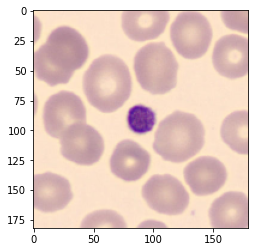

In [10]:
i = np.random.randint(0,len(df))
plt.imshow(images[i], cmap='gray')

## Deconvolution

In [37]:
def plot_deconv_single(idx, method):
    
    im = images[idx]
    deconv = color.separate_stains(im, method)

    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
    ax[0, 0].imshow(deconv[..., 0], cmap='Purples')
    hist, hist_centers = exposure.histogram(deconv[..., 0])
    ax[0, 1].plot(hist_centers, hist, lw=2)
    
    ax[1, 0].imshow(deconv[..., 1], cmap='pink_r')
    hist, hist_centers = exposure.histogram(deconv[..., 1])
    ax[1, 1].plot(hist_centers, hist, lw=2)
    
    ax[2, 0].imshow(deconv[..., 2], cmap='RdPu_r')
    hist, hist_centers = exposure.histogram(deconv[..., 2])
    ax[2, 1].plot(hist_centers, hist, lw=2)
    
    plt.show()

    return deconv, fig

In [14]:
methods = [color.bex_from_rgb, color.bpx_from_rgb, color.bro_from_rgb, 
           #color.gdx_from_rgb, color.hax_from_rgb, color.hdx_from_rgb, 
           color.hed_from_rgb, color.hpx_from_rgb, color.rbd_from_rgb]

1


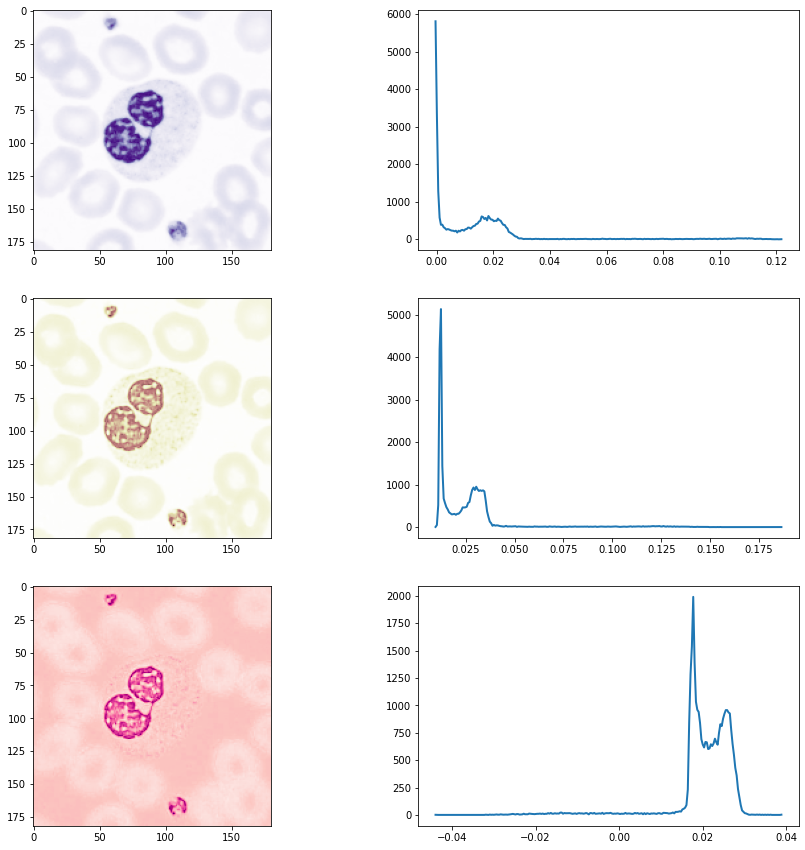

2


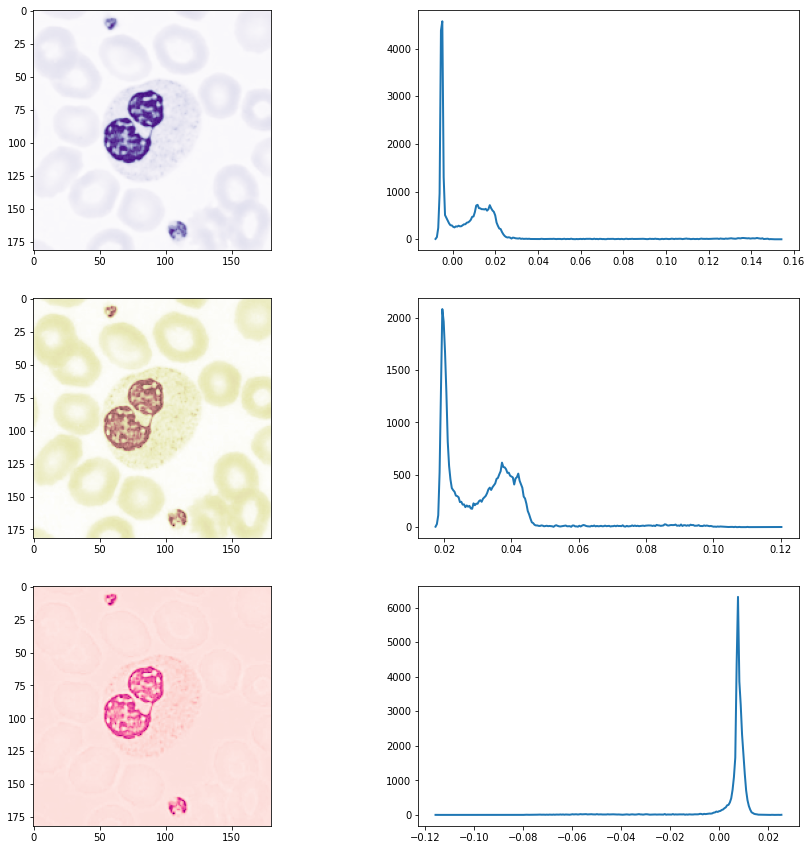

3


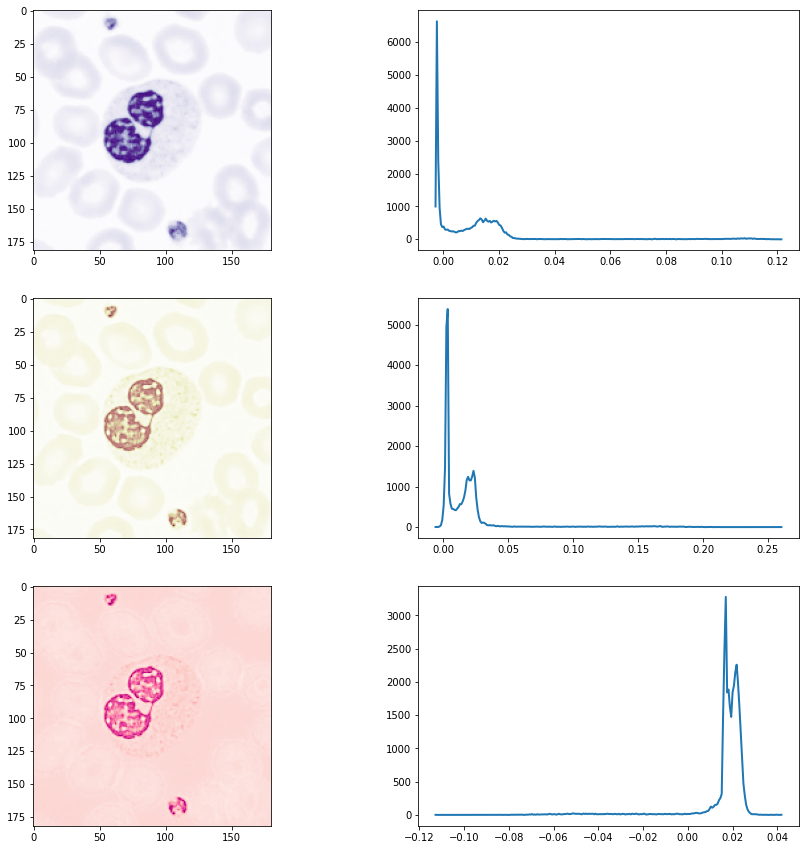

4


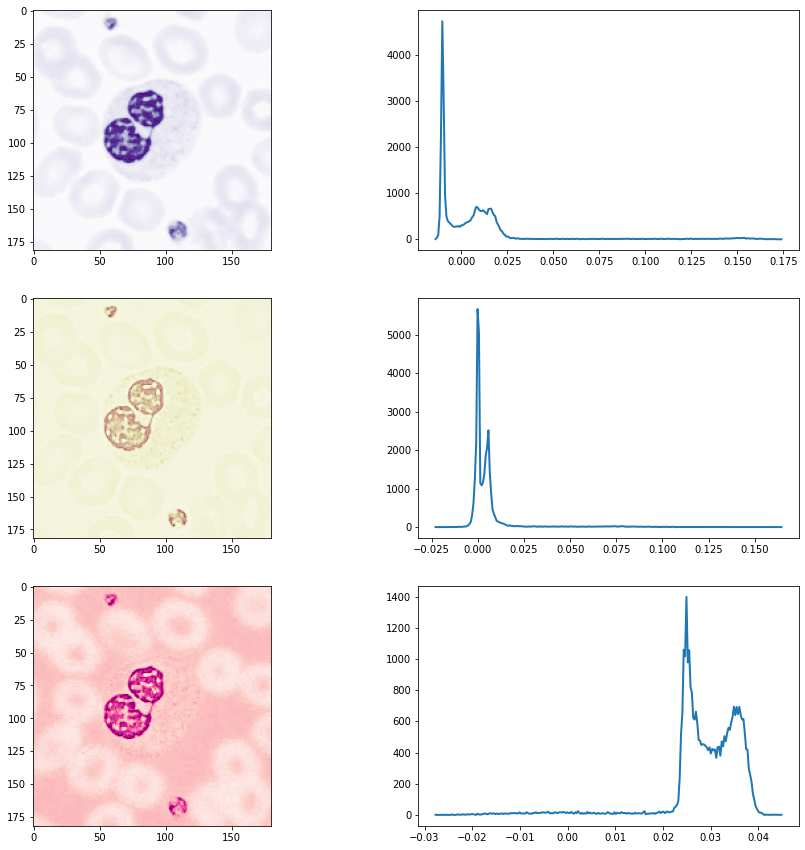

5


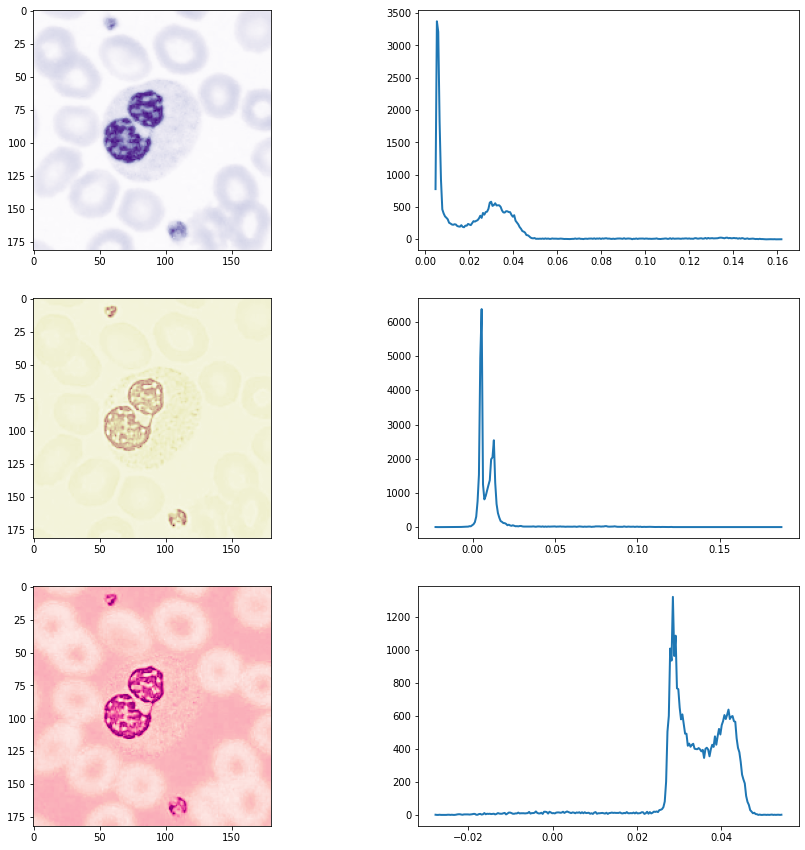

6


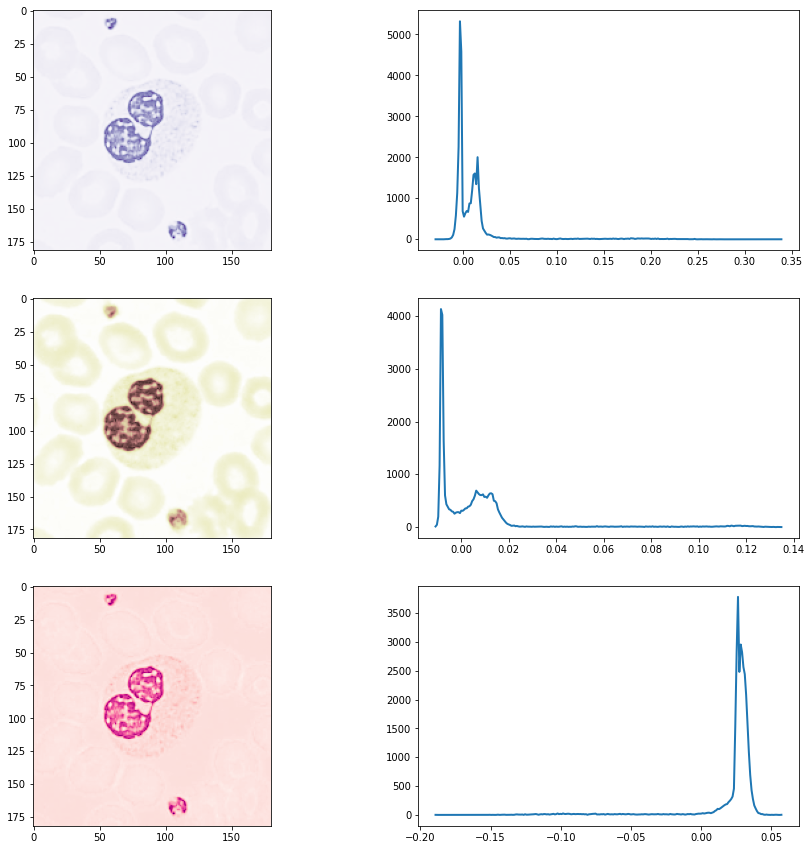

In [36]:
rand = np.random.choice(range(images.shape[0]))
for i, method in enumerate(methods):
    print(i+1, rand)
    plot_deconv_single(rand, method)

**The staining seems best deconvolved from the background with `bpx` (methyl blue + ponceau).**

Let's compare high and low brightness for large cells and small cells

In [442]:
def deconvolution_hist(image_arr, method=color.bpx_from_rgb):
    
    res = pd.DataFrame()
    
    for im in image_arr:
        temp = pd.DataFrame(index=[0])

        
        deconv = color.separate_stains(im, method)
        
        temp[['mean0', 'mean1', 'mean2']] = [np.mean(deconv, axis=(0, 1))]
        temp[['std1', 'std2', 'std3']] = [np.std(deconv, axis=(0, 1))]
        temp['hist0'] = [exposure.histogram(deconv[..., 0])]
        temp['hist1'] = [exposure.histogram(deconv[..., 1])]
        temp['hist2'] = [exposure.histogram(deconv[..., 2])]

        res = res.append(temp, ignore_index=True)
        
    return res

In [455]:
def box_plot(col, df):
    plt.figure(figsize = (16,6))
    plt.subplot(1,2,1)
    sns.boxplot(x = "label", y = col, data = df)

    plt.subplot(1,2,2)
    sns.kdeplot(x = col, hue = "label", data = df)
    
    plt.show()

In [450]:
res_deconv = deconvolution_hist(images)
res_deconv = df.join(res_deconv)
res_deconv.to_csv(Path('../../data/PBS_dataset_normal_resize_deconv.csv'), index=False)

### Mean luminance per channel following deconvolution

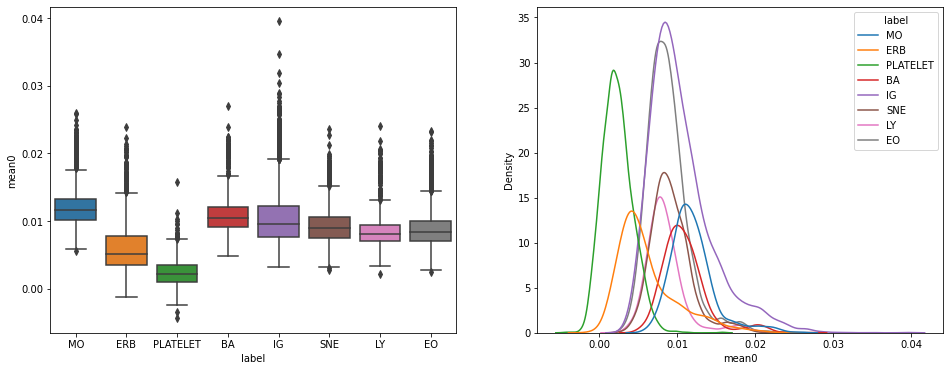

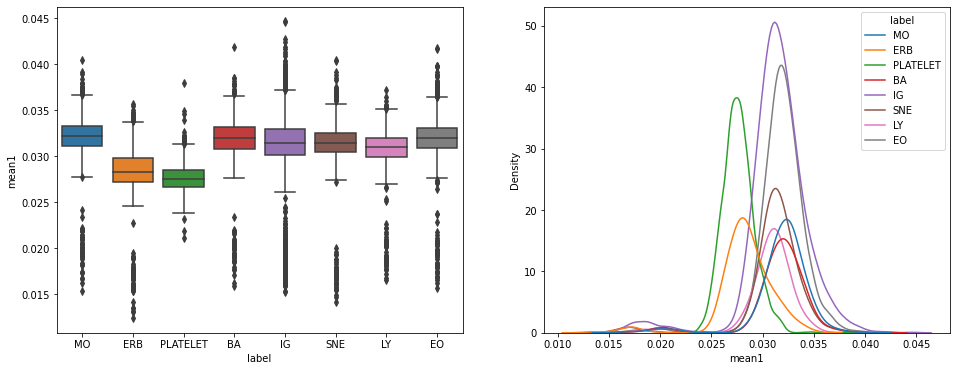

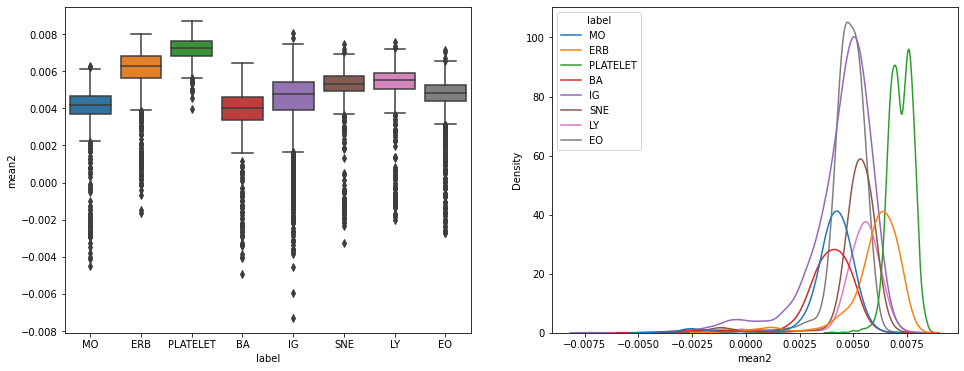

In [456]:
for col in ['mean0', 'mean1', 'mean2']:
    box_plot(col, res_deconv)


In [481]:
np.array(res_deconv[res_deconv.label=='MO']['hist0'])[:, 0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
def plot_deconv(idx, plot_gray=False):
    
    gray = images[idx]
    histo, histo_centers = exposure.histogram(gray)
    
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

    if plot_gray:
        ax[0].imshow(gray, cmap='gray')
    else: ax[0].imshow(im)

    ax[1].plot(histo_centers, histo, lw=2)
    ax[1].set_title('Gray-level histogram')
    plt.xlim([0, 1])

    plt.suptitle(df.loc[idx]['label'])
    plt.tight_layout()
    plt.show()
    return gray, histo, histo_centers, fig